# RESULTS
Here I report the full results of training of many different models.

There are a total of 81 different couples of parameters, for each a different model. ere I want to see how each model behaves.

In [54]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py

from pathlib import Path

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
prms = {'L' : 20,                # length of spin chain
        'sites' : [0, 1],        # sites of the subsystem S spins
        'omega' : 1,             # Rabi frequency
        # inverse temperature
        'beta' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        # interaction of subsystem's S spins
        'potential' : [0.1, 0.15, 0.2, 0.25, 0.3],       
        'potential_' : None,     # interaction of bath spins, if None same as potential
        'T' : 10,                # total time for the evolution
        'dt' : 0.01,             # interval every which save the data
        'cutoff' : 1e-8,         # cutoff for TEBD algorithm
        'im_cutoff' : 1e-10,      # cutoff for TEBD algorithm, img t-e
        'tolerance' : 1e-3,      # Trotter tolerance for TEBD algorithm
        'verbose' : True,        # verbosity of the script
        'num_traj' : 20,         # how many trajectories to do
        # file to save the data
        'fname' : './data/data_tebd_test.hdf5'
        }

ml_params = {'model_dir': './data/trained_model', # folder where the metadata of the training are stored
             'validation_split' : 0.8,
             'batch_size': 256,
             #'batches_per_epoch': 256,
             'n_epochs': 20,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt' : 0.01
                 },
             }

In [128]:
def print_comparison(data_tebd, data_ml, T, dt, ylim):
    t = np.arange(0, T, dt)[:-1]
        
    rows= 5
    columns = 3

    fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
    plt.setp(axs, xlim=(0,T), ylim=(-ylim, ylim))

    for i in range(rows):
        for j in range(columns):
            #if i == rows-1 & j == columns-1:
            #    continue
            axs[i, j].plot(t, [data_tebd[k][(columns-1)*i+j] for k in range(len(t))], label='Simulation', color='k')
            axs[i, j].plot(t, [data_ml[k][(columns-1)*i+j] for k in range(len(t))], label='ml', color='r', linestyle='--')
            axs[i, j].grid()
    axs[4, 2].grid()
    #plt.legend()
    plt.grid()

    fig = plt.gcf()
    plt.show()

### Import models and error calculation

In [129]:
from ml.classes import MLLP
from ml.utils import calculate_error

In [130]:
# for each set of parameters I import the TEBD data, 
# import the model and predict dynamics, and calculate the error

errors = []

for beta in prms['beta']:
    err = []
    for vv in prms['potential']:
        # import TEBD data
        gname = 'cohVec_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
        with h5py.File(prms['fname'], 'r') as f:
            data_tebd = f[gname+'/X'][()]

        # import the model
        name = 'model_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
                '_T' + str(int(prms['T']))

        model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
        model.load_state_dict(torch.load(Path('./data/trained_model/' + name)))
        
        # predict dynamics with the model
        ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=prms['T'])
        
        # calculate error
        err.append(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=prms['T'], dt=prms['dt']))
    errors.append(err)

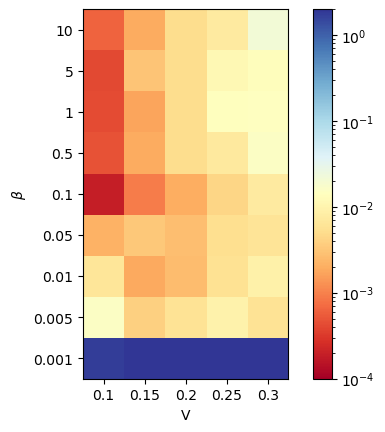

In [131]:
fig, ax = plt.subplots()

im = ax.imshow(errors, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.0001, vmax=2))

my_x_ticks = prms['potential']
my_y_ticks = prms['beta']
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'$\beta$')

fig.colorbar(im, ax=ax)

plt.show()

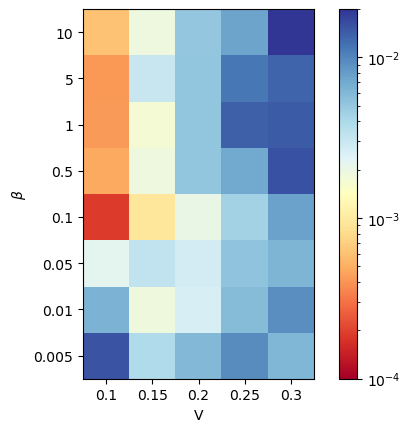

In [132]:
fig, ax = plt.subplots()

im = ax.imshow(errors[1:], origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.0001, vmax=0.02))

my_x_ticks = prms['potential']
my_y_ticks = prms['beta'][1:]
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'$\beta$')

fig.colorbar(im, ax=ax)

plt.show()

1.7430862008511079


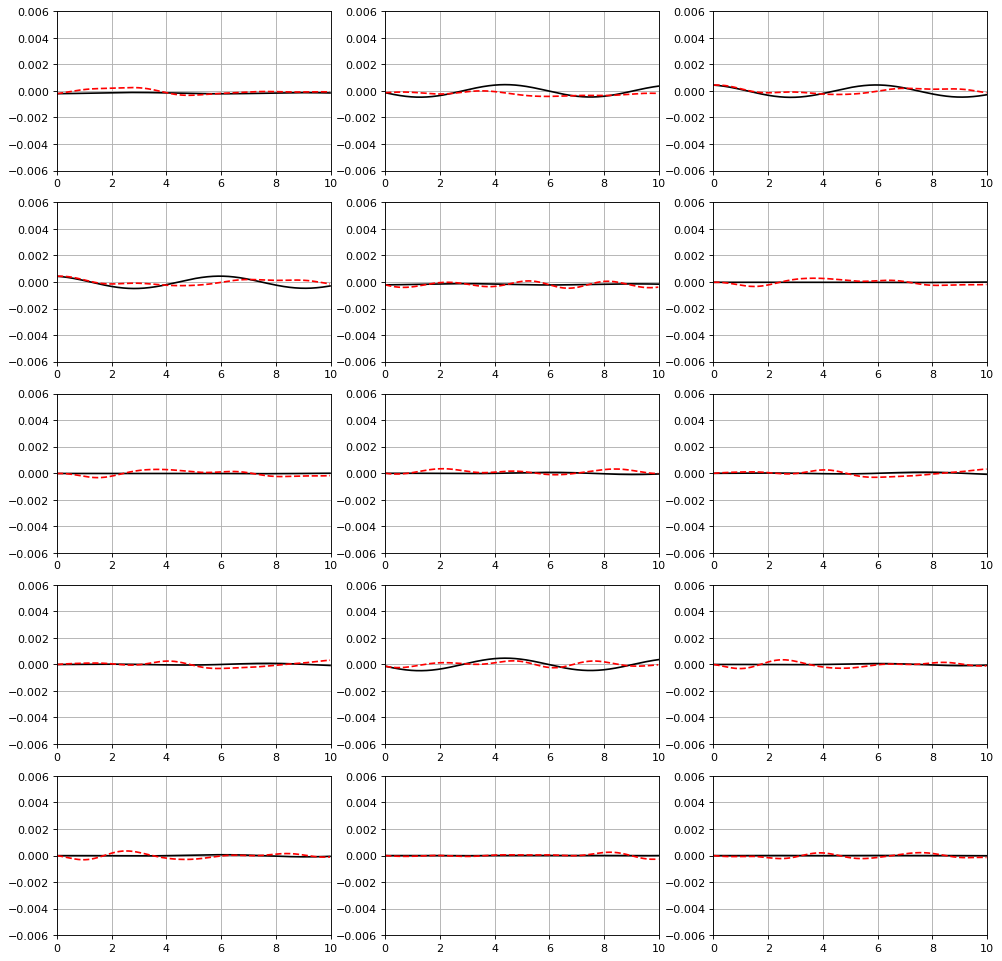

In [120]:
# perche' a temeprature alte fa schifo?
# import TEBD data
beta = 0.001
vv = 0.1

gname = 'cohVec_L_' + str(prms['L']) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_beta_' + str(int(beta*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
with h5py.File(prms['fname'], 'r') as f:
    data_tebd = f[gname+'/X'][()]

# import the model
name = 'model_L_' + str(prms['L']) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_beta_' + str(int(beta*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
        '_T' + str(int(prms['T']))

model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained_model/' + name)))

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=prms['T'])

print(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=prms['T'], dt=prms['dt']))

print_comparison(data_tebd, ml_dyn, prms['T'], prms['dt'], 0.006)

### Smaller training times make the difference?

In [121]:
# for each set of parameters I import the TEBD data, 
# import the model and predict dynamics, and calculate the error
T = 5

errors = []

for beta in prms['beta']:
    err = []
    for vv in prms['potential']:
        # import TEBD data
        gname = 'cohVec_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
        with h5py.File(prms['fname'], 'r') as f:
            data_tebd = f[gname+'/X'][()]

        # import the model
        name = 'model_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
                '_T' + str(int(T))

        model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
        model.load_state_dict(torch.load(Path('./data/trained_model/' + name)))
        
        # predict dynamics with the model
        ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=prms['T'])
        
        # calculate error
        err.append(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=prms['T'], dt=prms['dt']))
    errors.append(err)

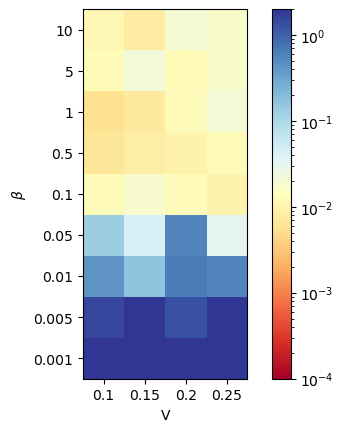

In [122]:
fig, ax = plt.subplots()

im = ax.imshow(errors, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.0001, vmax=2))

my_x_ticks = prms['potential']
my_y_ticks = prms['beta']
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'$\beta$')

fig.colorbar(im, ax=ax)

plt.show()

0.013045528466047167


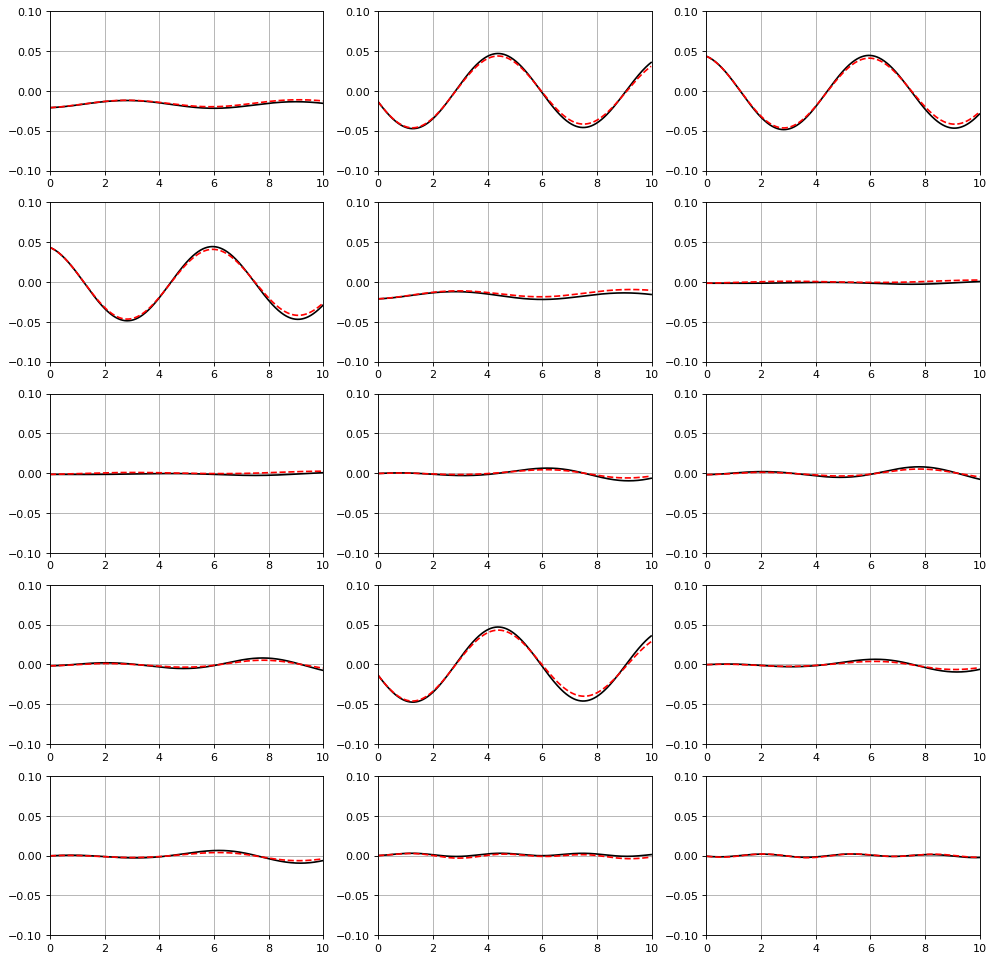

In [126]:
beta = 0.1
vv = 0.1
T = 5

gname = 'cohVec_L_' + str(prms['L']) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_beta_' + str(int(beta*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
with h5py.File(prms['fname'], 'r') as f:
    data_tebd = f[gname+'/X'][()]

# import the model
name = 'model_L_' + str(prms['L']) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_beta_' + str(int(beta*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
        '_T' + str(int(5))

model = MLLP(ml_params['mlp_params']).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained_model/' + name)))

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=prms['T'])

print(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=prms['T'], dt=prms['dt']))

print_comparison(data_tebd, ml_dyn, prms['T'], prms['dt'], 0.1)